In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils.etoile_achat_ventes import graphe_etoile_achats_ventes

DATA_PATH = "../donnees/ecommerce/"

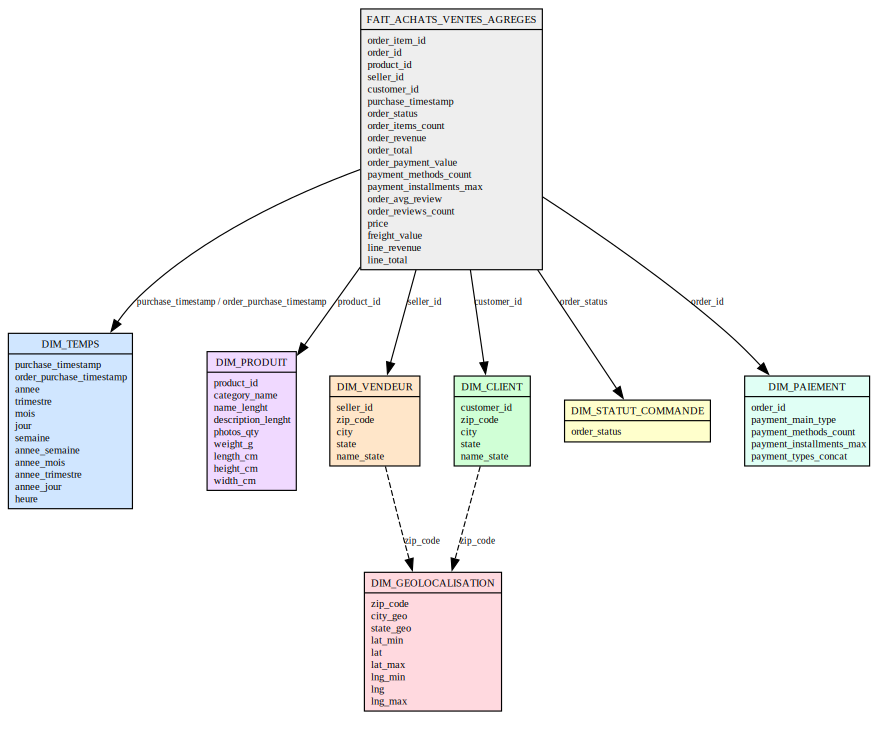

In [3]:
dot_achats = graphe_etoile_achats_ventes()
dot_achats

In [4]:
# -----------------------------------------------------------
# 1) LECTURE DES TABLES
# -----------------------------------------------------------
orders    = pd.read_parquet(DATA_PATH + "orders.parquet")
items     = pd.read_parquet(DATA_PATH + "items.parquet")
customers = pd.read_parquet(DATA_PATH + "customers.parquet")
payments  = pd.read_parquet(DATA_PATH + "payments.parquet")
reviews   = pd.read_parquet(DATA_PATH + "reviews.parquet")

print("Shapes brutes :")
print("orders   :", orders.shape)
print("items    :", items.shape)
print("customers:", customers.shape)
print("payments :", payments.shape)
print("reviews  :", reviews.shape)


# -----------------------------------------------------------
# 2) FACT DE BASE : F_ACHATS (grain = ligne d'article)
# -----------------------------------------------------------

# 2.1) Items (lignes d'achat)
items_fact = items[[
    "order_id",
    "order_item_id",
    "product_id",
    "seller_id",
    "price",
    "freight_value",
]].copy()

# 2.2) Orders (client, statut, timestamp)
# on renomme 'status' -> 'order_status' si besoin
if "status" in orders.columns and "order_status" not in orders.columns:
    orders = orders.rename(columns={"status": "order_status"})

orders_fact = orders[[
    "order_id",
    "customer_id",
    "purchase_timestamp",
    "order_status",
]].copy()

# 2.3) Customers (zip_code pour localisation)
cust_fact = customers[["customer_id", "zip_code"]].copy()

# 2.4) Jointure -> F_ACHATS
F_ACHATS = (
    items_fact
    .merge(orders_fact, on="order_id", how="left")
    .merge(cust_fact,   on="customer_id", how="left")
)

# métriques de ligne
F_ACHATS["line_revenue"] = F_ACHATS["price"]
F_ACHATS["line_total"]   = F_ACHATS["price"] + F_ACHATS["freight_value"]

print("F_ACHATS shape :", F_ACHATS.shape)


# -----------------------------------------------------------
# 3) AGRÉGATION PAR COMMANDE (ventes)
#    -> order_items_count, order_revenue, order_total
# -----------------------------------------------------------

agg_orders = (
    F_ACHATS
    .groupby("order_id", as_index=False)
    .agg(
        order_items_count=("order_item_id", "count"),
        order_revenue=("price", "sum"),
        order_total=("line_total", "sum"),
    )
)

print("agg_orders shape :", agg_orders.shape)


# -----------------------------------------------------------
# 4) AGRÉGATION DES PAIEMENTS (table brute Kaggle)
#    -> order_payment_value, payment_methods_count,
#       payment_installments_max, payment_main_type,
#       payment_types_concat
# -----------------------------------------------------------

# on enlève le préfixe "payment_" si présent
pay = payments.rename(columns=lambda c: c.replace("payment_", ""))

# agrégats simples par commande
PAY_AGG = (
    pay
    .groupby("order_id", as_index=False)
    .agg(
        order_payment_value=("value", "sum"),
        payment_methods_count=("type", "nunique"),
        payment_installments_max=("installments", "max"),
    )
)

# concaténation des types de paiement utilisés
types_concat = (
    pay
    .groupby("order_id")["type"]
    .apply(lambda x: "+".join(sorted(x.unique())))
    .reset_index(name="payment_types_concat")
)

# type principal = type avec la plus grande valeur payée
pay_type_value = (
    pay
    .groupby(["order_id", "type"], as_index=False)["value"]
    .sum()
)
idx_max = pay_type_value.groupby("order_id")["value"].idxmax()
main_type = (
    pay_type_value
    .loc[idx_max, ["order_id", "type"]]
    .rename(columns={"type": "payment_main_type"})
)

PAY_AGG = (
    PAY_AGG
    .merge(types_concat, on="order_id", how="left")
    .merge(main_type,    on="order_id", how="left")
)

print("PAY_AGG shape :", PAY_AGG.shape)
print(PAY_AGG.head(3))


# -----------------------------------------------------------
# 5) AGRÉGATION DES AVIS
#    -> order_avg_review, order_reviews_count
# -----------------------------------------------------------

rev = reviews.copy()

# colonnes score_1..5 = nb d'avis par score
score_detail_cols = [c for c in rev.columns if c.startswith("score_") and c != "score"]

rev["order_reviews_count"] = rev[score_detail_cols].sum(axis=1)
rev["order_avg_review"] = rev["score"] / rev["order_reviews_count"]
rev.loc[rev["order_reviews_count"] == 0, "order_avg_review"] = pd.NA

REV_AGG = rev[["order_id", "order_avg_review", "order_reviews_count"]].copy()

print("REV_AGG shape :", REV_AGG.shape)
print(REV_AGG.head(3))


# -----------------------------------------------------------
# 6) FACT F_ACHATS_VENTES_AGREGES
#    (grain = ligne d'article, enrichie par
#     agrégats commande + paiements + avis)
# -----------------------------------------------------------

F_ACHATS_VENTES_AGREGES = (
    F_ACHATS
    .merge(agg_orders, on="order_id", how="left")
    .merge(PAY_AGG,     on="order_id", how="left")
    .merge(REV_AGG,     on="order_id", how="left")
)

cols_fact = [
    "order_item_id",
    "order_id",
    "product_id",
    "seller_id",
    "customer_id",
    "purchase_timestamp",
    "order_status",
    "order_items_count",
    "order_revenue",
    "order_total",
    "order_payment_value",
    "payment_methods_count",
    "payment_installments_max",
    "payment_main_type",
    "payment_types_concat",
    "order_avg_review",
    "order_reviews_count",
    "price",
    "freight_value",
    "line_revenue",
    "line_total",
]

F_ACHATS_VENTES_AGREGES = F_ACHATS_VENTES_AGREGES[cols_fact]

print("F_ACHATS_VENTES_AGREGES shape :", F_ACHATS_VENTES_AGREGES.shape)
print("Colonnes (", len(F_ACHATS_VENTES_AGREGES.columns), "):")
print(list(F_ACHATS_VENTES_AGREGES.columns))
display(F_ACHATS_VENTES_AGREGES.head(5))


# -----------------------------------------------------------
# 7) SAUVEGARDE UNIQUE : FACT ACHATS + VENTES AGRÉGÉES
# -----------------------------------------------------------

OUTPUT_FACT = "f_achats_ventes_agreges.parquet"  # adapte si besoin
F_ACHATS_VENTES_AGREGES.to_parquet(OUTPUT_FACT, index=False)
print(f"F_ACHATS_VENTES_AGREGES sauvegardé dans : {OUTPUT_FACT}")


Shapes brutes :
orders   : (99441, 23)
items    : (112650, 8)
customers: (99441, 6)
payments : (103886, 5)
reviews  : (98673, 25)
F_ACHATS shape : (112650, 12)
agg_orders shape : (98666, 4)
PAY_AGG shape : (99440, 6)
                           order_id  order_payment_value  \
0  00010242fe8c5a6d1ba2dd792cb16214                72.19   
1  00018f77f2f0320c557190d7a144bdd3               259.83   
2  000229ec398224ef6ca0657da4fc703e               216.87   

   payment_methods_count  payment_installments_max payment_types_concat  \
0                      1                         2          credit_card   
1                      1                         3          credit_card   
2                      1                         5          credit_card   

  payment_main_type  
0       credit_card  
1       credit_card  
2       credit_card  
REV_AGG shape : (98673, 3)
                           order_id  order_avg_review  order_reviews_count
0  00010242fe8c5a6d1ba2dd792cb16214               5

,order_item_id,order_id,product_id,seller_id,customer_id,purchase_timestamp,order_status,order_items_count,order_revenue,order_total,...,payment_methods_count,payment_installments_max,payment_main_type,payment_types_concat,order_avg_review,order_reviews_count,price,freight_value,line_revenue,line_total
0,1,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02,delivered,1,58.90,72.19,...,1.0,2.0,credit_card,credit_card,5.0,1.0,58.90,13.29,58.90,72.19
1,1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,f6dd3ec061db4e3987629fe6b26e5cce,2017-04-26 10:53:06,delivered,1,239.90,259.83,...,1.0,3.0,credit_card,credit_card,4.0,1.0,239.90,19.93,239.90,259.83
2,1,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,6489ae5e4333f3693df5ad4372dab6d3,2018-01-14 14:33:31,delivered,1,199.00,216.87,...,1.0,5.0,credit_card,credit_card,5.0,1.0,199.00,17.87,199.00,216.87
3,1,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,d4eb9395c8c0431ee92fce09860c5a06,2018-08-08 10:00:35,delivered,1,12.99,25.78,...,1.0,2.0,credit_card,credit_card,4.0,1.0,12.99,12.79,12.99,25.78
4,1,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,58dbd0b2d70206bf40e62cd34e84d795,2017-02-04 13:57:51,delivered,1,199.90,218.04,...,1.0,3.0,credit_card,credit_card,5.0,1.0,199.90,18.14,199.90,218.04


F_ACHATS_VENTES_AGREGES sauvegardé dans : f_achats_ventes_agreges.parquet


In [5]:
# Analyse 1  Complexité des commandes, valeur et satisfaction
# Dans cette première analyse sur l’étoile 3, on veut relier le détail des lignes
# d’achats (price, freight_value, line_total) aux indicateurs agrégés de commande
# (order_items_count, order_total, order_payment_value) et au profil de paiement
# (payment_methods_count, payment_installments_max, payment_main_type).
# On analysera comment la satisfaction client (order_avg_review) varie selon la
# “complexité” des commandes, en suivant les hiérarchies de temps (année, mois),
# de statut de commande (delivered, canceled, etc.) et de profil de paiement,
# pour identifier les combinaisons de panier et de paiement qui performent le mieux.


In [6]:
# Hypothèse 1
# On suppose que les commandes les plus complexes (order_total élevé, beaucoup
# d’articles, plusieurs moyens de paiement et/ou beaucoup d’installments) génèrent
# en moyenne plus de frictions et donc des scores d’avis plus faibles.
# À l’inverse, les commandes simples (petit panier, un seul moyen de paiement,
# peu d’installments) seraient plus fluides et aboutiraient à davantage de notes
# maximales. On s’attend donc à voir une baisse progressive de order_avg_review
# quand on passe des petites commandes simples aux grosses commandes complexes,
# surtout pour certains statuts (livraisons en retard, commandes annulées).


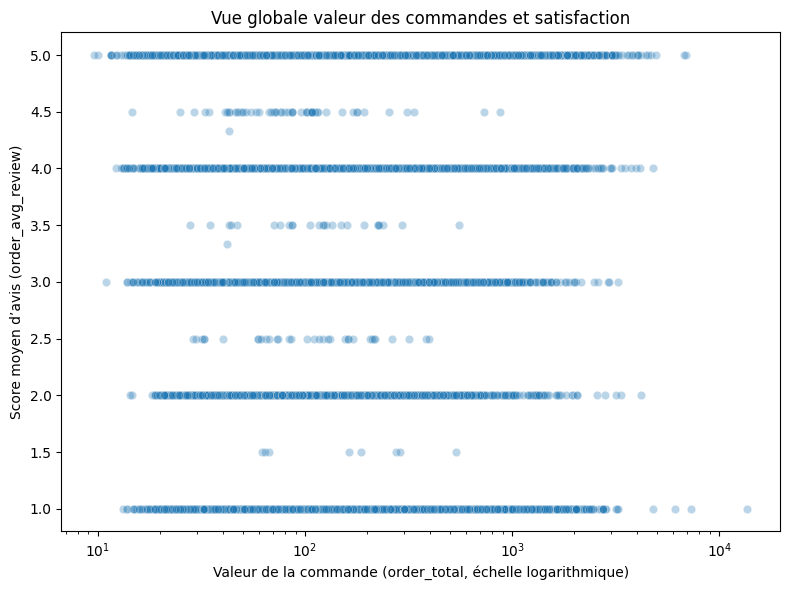

In [9]:
# 1 Vue globale valeur des commandes et satisfaction (order_total vs order_avg_review)
#préparation
orders_level = (
    F_ACHATS_VENTES_AGREGES
    .dropna(subset=["order_total", "order_avg_review"])
    .drop_duplicates("order_id")
)
orders_level = orders_level[orders_level["order_total"] > 0]
#affichage
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=orders_level,
    x="order_total",
    y="order_avg_review",
    alpha=0.3
)
plt.xscale("log")
plt.xlabel("Valeur de la commande (order_total, échelle logarithmique)")
plt.ylabel("Score moyen d’avis (order_avg_review)")
plt.title("Vue globale valeur des commandes et satisfaction")
plt.tight_layout()
plt.show()

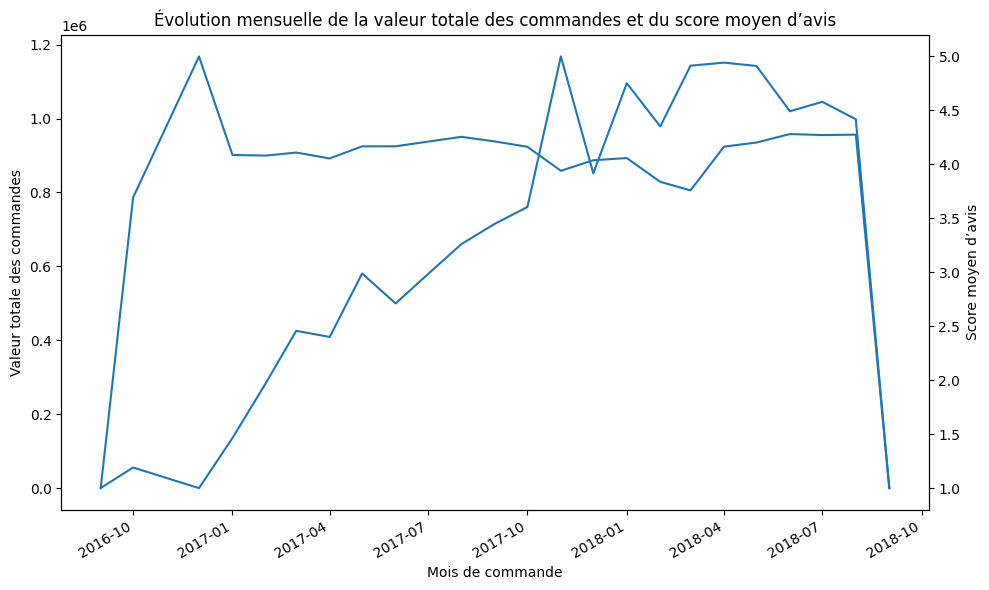

In [10]:
# 2 Évolution mensuelle de la valeur totale des commandes et du score moyen d’avis
#préparation
orders_level = (
    F_ACHATS_VENTES_AGREGES
    .dropna(subset=["order_total", "order_avg_review", "purchase_timestamp"])
    .drop_duplicates("order_id")
    .copy()
)
orders_level["order_month"] = orders_level["purchase_timestamp"].dt.to_period("M").dt.to_timestamp()
monthly = (
    orders_level
    .groupby("order_month", as_index=False)
    .agg(
        total_order_value=("order_total", "sum"),
        avg_review=("order_avg_review", "mean")
    )
)
#affichage
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
ax1.plot(monthly["order_month"], monthly["total_order_value"])
ax2.plot(monthly["order_month"], monthly["avg_review"])
ax1.set_xlabel("Mois de commande")
ax1.set_ylabel("Valeur totale des commandes")
ax2.set_ylabel("Score moyen d’avis")
ax1.set_title("Évolution mensuelle de la valeur totale des commandes et du score moyen d’avis")
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

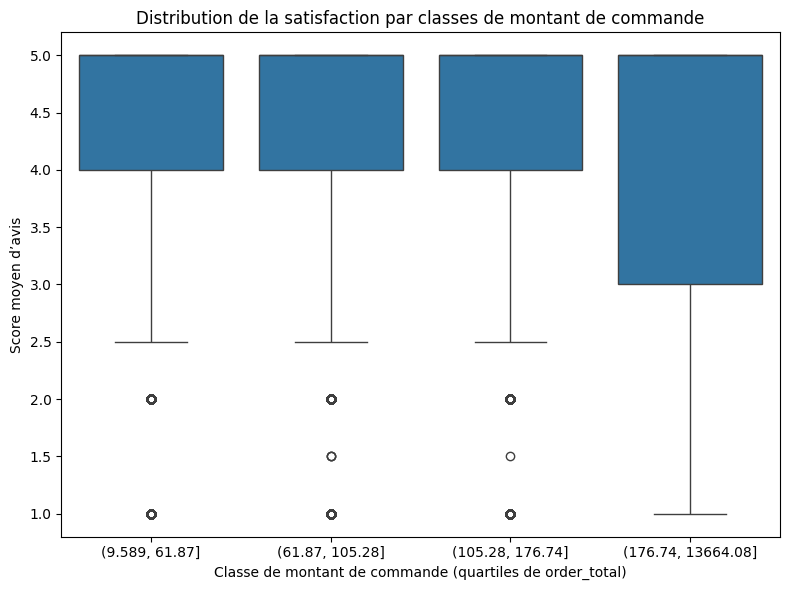

In [11]:
# 3 Distribution de la satisfaction par classes de montant de commande (petites vs grosses commandes)
#préparation
orders_level = (
    F_ACHATS_VENTES_AGREGES
    .dropna(subset=["order_total", "order_avg_review"])
    .drop_duplicates("order_id")
    .copy()
)
orders_level = orders_level[orders_level["order_total"] > 0]
orders_level["order_total_class"] = pd.qcut(
    orders_level["order_total"],
    q=4,
    duplicates="drop"
)
#affichage
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=orders_level,
    x="order_total_class",
    y="order_avg_review"
)
plt.xlabel("Classe de montant de commande (quartiles de order_total)")
plt.ylabel("Score moyen d’avis")
plt.title("Distribution de la satisfaction par classes de montant de commande")
plt.tight_layout()
plt.show()

In [12]:
# 4 Impact du nombre d’articles par commande (order_items_count) sur le score moyen d’avis
#préparation
orders_level = (
    F_ACHATS_VENTES_AGREGES
    .dropna(subset=["order_items_count", "order_avg_review"])
    .drop_duplicates("order_id")
    .copy()
)
orders_level = orders_level[orders_level["order_items_count"] > 0]
orders_level["items_class"] = pd.cut(
    orders_level["order_items_count"],
    bins=[0, 1, 2, 3, 5, np.inf],
    labels=["1", "2", "3-4", "5+", "5+"]
)
orders_level["items_class"] = orders_level["items_class"].cat.remove_unused_categories()
avg_by_items = (
    orders_level
    .groupby("items_class", as_index=False)["order_avg_review"]
    .mean()
)
#affichage
plt.figure(figsize=(8, 6))
sns.barplot(
    data=avg_by_items,
    x="items_class",
    y="order_avg_review"
)
plt.xlabel("Nombre d’articles par commande (classes)")
plt.ylabel("Score moyen d’avis")
plt.title("Impact du nombre d’articles par commande sur le score moyen d’avis")
plt.tight_layout()
plt.show()

ValueError: labels must be unique if ordered=True; pass ordered=False for duplicate labels

In [13]:
# 5 Complexité du panier : croisement valeur de commande et nombre d’articles vs satisfaction
#préparation
orders_level = (
    F_ACHATS_VENTES_AGREGES
    .dropna(subset=["order_total", "order_items_count", "order_avg_review"])
    .drop_duplicates("order_id")
    .copy()
)
orders_level = orders_level[orders_level["order_total"] > 0]
orders_level["order_total_class"] = pd.qcut(
    orders_level["order_total"],
    q=4,
    duplicates="drop"
)
orders_level = orders_level[orders_level["order_items_count"] > 0]
orders_level["items_class"] = pd.cut(
    orders_level["order_items_count"],
    bins=[0, 1, 2, 3, 5, np.inf],
    labels=["1", "2", "3-4", "5+", "5+"]
)
orders_level["items_class"] = orders_level["items_class"].cat.remove_unused_categories()
heat = (
    orders_level
    .groupby(["items_class", "order_total_class"], as_index=False)["order_avg_review"]
    .mean()
)
pivot = heat.pivot(index="items_class", columns="order_total_class", values="order_avg_review")
#affichage
plt.figure(figsize=(8, 6))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".2f"
)
plt.xlabel("Classe de montant de commande (order_total)")
plt.ylabel("Classe de nombre d’articles (order_items_count)")
plt.title("Complexité du panier : valeur de commande et nombre d’articles vs satisfaction")
plt.tight_layout()
plt.show()

ValueError: labels must be unique if ordered=True; pass ordered=False for duplicate labels

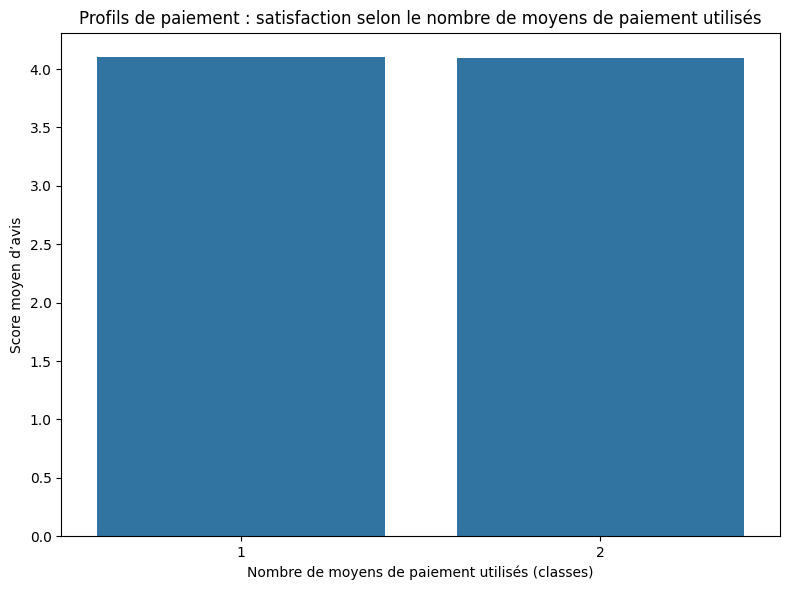

In [14]:
# 6 Profils de paiement : satisfaction selon le nombre de moyens de paiement utilisés (payment_methods_count)
#préparation
orders_level = (
    F_ACHATS_VENTES_AGREGES
    .dropna(subset=["payment_methods_count", "order_avg_review"])
    .drop_duplicates("order_id")
    .copy()
)
orders_level["methods_class_num"] = orders_level["payment_methods_count"].clip(lower=1, upper=3)
orders_level["methods_class"] = orders_level["methods_class_num"].map({1: "1", 2: "2", 3: "3 et plus"})
avg_by_methods = (
    orders_level
    .groupby("methods_class", as_index=False)["order_avg_review"]
    .mean()
)
#affichage
plt.figure(figsize=(8, 6))
sns.barplot(
    data=avg_by_methods,
    x="methods_class",
    y="order_avg_review"
)
plt.xlabel("Nombre de moyens de paiement utilisés (classes)")
plt.ylabel("Score moyen d’avis")
plt.title("Profils de paiement : satisfaction selon le nombre de moyens de paiement utilisés")
plt.tight_layout()
plt.show()

C:\Users\donic\AppData\Local\Temp\ipykernel_61644\2291321629.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("installments_class", as_index=False)["order_avg_review"]


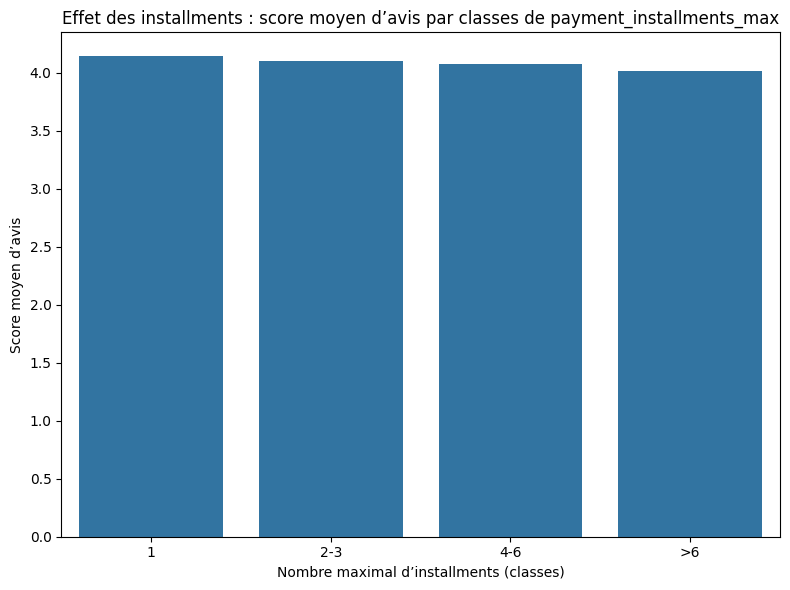

In [15]:
# 7 Effet des installments : score moyen d’avis par classes de payment_installments_max
#préparation
orders_level = (
    F_ACHATS_VENTES_AGREGES
    .dropna(subset=["payment_installments_max", "order_avg_review"])
    .drop_duplicates("order_id")
    .copy()
)
orders_level = orders_level[orders_level["payment_installments_max"] >= 0]
orders_level["installments_class"] = pd.cut(
    orders_level["payment_installments_max"],
    bins=[-0.1, 1, 3, 6, np.inf],
    labels=["1", "2-3", "4-6", ">6"]
)
avg_by_installments = (
    orders_level
    .groupby("installments_class", as_index=False)["order_avg_review"]
    .mean()
)
#affichage
plt.figure(figsize=(8, 6))
sns.barplot(
    data=avg_by_installments,
    x="installments_class",
    y="order_avg_review"
)
plt.xlabel("Nombre maximal d’installments (classes)")
plt.ylabel("Score moyen d’avis")
plt.title("Effet des installments : score moyen d’avis par classes de payment_installments_max")
plt.tight_layout()
plt.show()


C:\Users\donic\AppData\Local\Temp\ipykernel_61644\2904613841.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["order_status", "order_total_class"], as_index=False)["order_avg_review"]


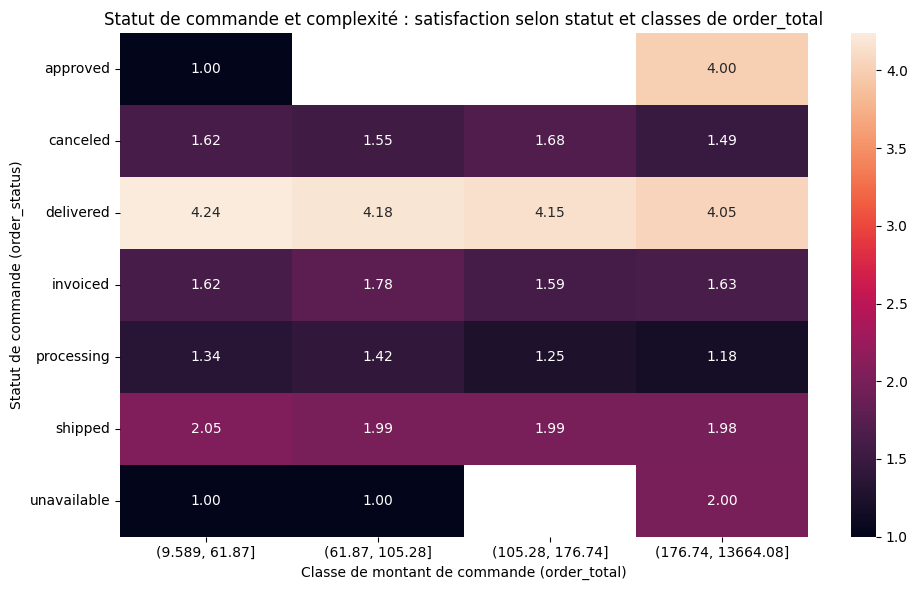

In [16]:
# 8 Statut de commande et complexité : satisfaction selon order_status et classes de order_total
#préparation
orders_level = (
    F_ACHATS_VENTES_AGREGES
    .dropna(subset=["order_total", "order_status", "order_avg_review"])
    .drop_duplicates("order_id")
    .copy()
)
orders_level = orders_level[orders_level["order_total"] > 0]
orders_level["order_total_class"] = pd.qcut(
    orders_level["order_total"],
    q=4,
    duplicates="drop"
)
heat = (
    orders_level
    .groupby(["order_status", "order_total_class"], as_index=False)["order_avg_review"]
    .mean()
)
pivot = heat.pivot(index="order_status", columns="order_total_class", values="order_avg_review")
#affichage
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".2f"
)
plt.xlabel("Classe de montant de commande (order_total)")
plt.ylabel("Statut de commande (order_status)")
plt.title("Statut de commande et complexité : satisfaction selon statut et classes de order_total")
plt.tight_layout()
plt.show()


In [17]:
# 9 Typologie des paiements : satisfaction par payment_main_type et type de panier (commandes simples vs complexes)
#préparation
orders_level = (
    F_ACHATS_VENTES_AGREGES
    .dropna(subset=["order_items_count", "order_avg_review"])
    .drop_duplicates("order_id")
    .copy()
)
dim_paiement = pd.read_parquet(DATA_PATH + "dim_paiement.parquet")
if "order_id" not in dim_paiement.columns:
    dim_paiement = dim_paiement.reset_index().rename(columns={"index": "order_id"})
cols_dim = [c for c in dim_paiement.columns if c in ["order_id", "payment_main_type"]]
orders_level = orders_level.merge(
    dim_paiement[cols_dim],
    on="order_id",
    how="left"
)
orders_level = orders_level.dropna(subset=["payment_main_type"])
orders_level["basket_type"] = np.where(
    orders_level["order_items_count"] == 1,
    "Panier simple (1 ligne)",
    "Panier complexe (2+ lignes)"
)
top_types = (
    orders_level["payment_main_type"]
    .value_counts()
    .head(6)
    .index
)
orders_level = orders_level[orders_level["payment_main_type"].isin(top_types)]
heat = (
    orders_level
    .groupby(["payment_main_type", "basket_type"], as_index=False)["order_avg_review"]
    .mean()
)
pivot = heat.pivot(index="payment_main_type", columns="basket_type", values="order_avg_review")
#affichage
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".2f"
)
plt.xlabel("Type de panier")
plt.ylabel("Type de paiement principal")
plt.title("Typologie des paiements : satisfaction par payment_main_type et type de panier")
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../donnees/ecommerce/dim_paiement.parquet'